In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Load image and preprocess
def load_img(path):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

# Show image
def show_img(tensor, title):
    img = tensor.squeeze().detach().cpu().permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
# Load images
content = load_img('content.jpg')
style = load_img('style.jpg')

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content = content.to(device)
style = style.to(device)

# Load VGG
vgg = models.vgg19(pretrained=True).features.to(device).eval()

C:\Users\niraj_1kwckht\anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\niraj_1kwckht\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Get features
def get_features(x, layers):
    feats = {}
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in layers:
            feats[name] = x
    return feats

# Gram matrix
def gram(x):
    b, c, h, w = x.size()
    x = x.view(c, h * w)
    return torch.mm(x, x.t())

In [5]:
# Layers to use
content_layer = ['21']
style_layers = ['0', '5', '10', '19', '28']

# Extract features without tracking gradients
with torch.no_grad():
    c_feats = get_features(content, content_layer + style_layers)
    s_feats = get_features(style, style_layers)
    s_grams = {l: gram(s_feats[l]) for l in style_layers}

# Target image to optimize
target = content.clone().requires_grad_(True)

# Optimizer
opt = torch.optim.Adam([target], lr=0.01)

Step 0, Loss: 25257826058240.0


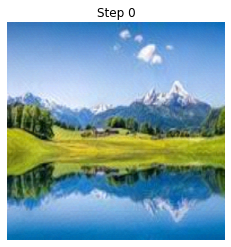

In [ ]:
# Style transfer loop
for step in range(201):
    t_feats = get_features(target, content_layer + style_layers)
    c_loss = torch.mean((t_feats['21'] - c_feats['21'])**2)
    s_loss = 0
    for l in style_layers:
        s_loss += torch.mean((gram(t_feats[l]) - s_grams[l])**2)
    loss = c_loss + 1e6 * s_loss

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss.item()}")
        show_img(target, f"Step {step}")

# Final result
show_img(target, "Final Stylized Image")